In [1]:
using NBInclude
@nbinclude("functions.ipynb")

All function imported


In [14]:
# setup
# experiments with MNIST dataset

x_dim = 400
k = 20
tolerance = 1e-7; max_iter = 4000; out_toggle = 0
trials = 20
n1 = 100
opt = Flux.Optimise.ADAM(.1);
m_list = 15:5:150

A = sample_fourier(n1, x_dim); A = A' #sub-sampled DCT matrix used in convex combination
B = randn(x_dim, n1)/sqrt(x_dim) #random matrix that is used in convex combination
W1 = randn(n1,k)/sqrt(n1)

z = randn(k) # ground code vector
F = dct(diagm(ones(x_dim)),2);

β_list, α_list = get_β_α(F, A, B, 21);

In [ ]:
phase_matrix_recovery = zeros(trials, length(m_list), length(β_list))
phase_matrix_recon = zeros(trials, length(m_list), length(β_list))

Threads.@threads for i in 1:length(m_list)
    m = m_list[i]
    recovery_error_matrix = zeros(trials)
    recon_error_matrix = zeros(trials)
    for β in β_list
        recovery_error_list = []
        recon_error_list = []
        G = Chain(
            Dense(k, n1, relu, bias = false; init =(out,in) -> W1),
            Dense(n1, x_dim, identity, bias = false; init =(out,in) -> β*A + (1-β) * B)
        )    #setup the generative network 

        for trials in 1:trials
            F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
            F_sub = F_sub * sqrt(x_dim)/sqrt(m) #normalization          
            y = F_sub * G(z) # measurement vector using subsampled DCT matrix
    
            z_est = randn(k) #initialization for algorithm
            z_est = estimated_code(opt, G, y, F_sub, z_est; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem

            push!(recovery_error_list, relative_error(z, z_est))    
            push!(recon_error_list, relative_error(G(z), G(z_est)))
        end

        recovery_error_matrix =  hcat(recovery_error_matrix, recovery_error_list)
        recon_error_matrix = hcat(recon_error_matrix, recon_error_list)
    end
    phase_matrix_recovery[:, i, :] = recovery_error_matrix[:, 2:end]
    phase_matrix_recon[:, i, :] = recon_error_matrix[:, 2:end]
    println("Done with m = $m")
    println("")
end

In [4]:
# save("saved_data/Phase_plot_random.jld", "phase_matrix_recovery", phase_matrix_recovery, "phase_matrix_recon", phase_matrix_recon, "α_list", α_list, "m_list", m_list, "trials", trials)
phase_matrix_recovery = load("saved_data/Phase_plot_random.jld", "phase_matrix_recovery")
phase_matrix_recon = load("saved_data/Phase_plot_random.jld", "phase_matrix_recon")
α_list = load("saved_data/Phase_plot_random.jld", "α_list")
m_list = load("saved_data/Phase_plot_random.jld", "m_list")
trials = load("saved_data/Phase_plot_random.jld", "trials")


20

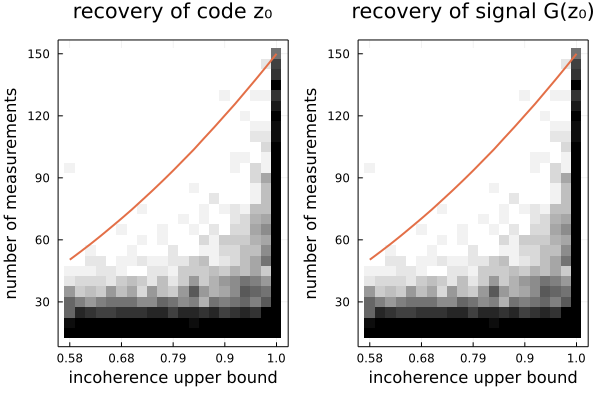

In [5]:
M = zeros(size(phase_matrix_recovery[1,:,:]))
for trial in 1:trials
    M += (phase_matrix_recovery[trial,:,:] .< 1e-5)
end

M = zeros(size(phase_matrix_recon[1,:,:]))
for trial in 1:trials
    M += (phase_matrix_recovery[trial,:,:] .< 1e-5)
end

p1 = plot(colorview(Gray, reverse(M/trials, dims = 1)), bg =:black, title = "recovery of code z₀", framestyle = :box)
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 1:6:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 1:6:length(m_list)])

m_pred = 150*α_list.^2
ff(x) = -27/135 * x +(1 + 27*150/135)
plot!(1:length(α_list), ff.(m_pred), label =:false, linewidth = 2 )

# m_pred = 150*α_list.^3
# plot!(1:length(α_list), ff.(m_pred), label =:false, linewidth = 2 )

p2 = plot(colorview(Gray, reverse(M/trials, dims = 1)), bg =:black, title = "recovery of signal G(z₀)",framestyle = :box)
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 1:6:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 1:6:length(m_list)])
plot!(1:length(α_list), ff.(m_pred), label =:false, linewidth = 2 )

plot(p1, p2, layout = 2, xlabel = "incoherence upper bound", ylabel = "number of measurements")
# savefig("figures/Phase_plot_random_percentage.pdf")



In [33]:


M = sum(phase_matrix_recovery,dims =1)[1,:,:]/20; M[M .>1] .= 1
p1 = plot(colorview(Gray, reverse(M,dims=1)), framestyle = :box, bg =:black, title = "recovery of code z₀")
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 1:6:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 1:6:length(m_list)])

M = sum(phase_matrix_recon,dims =1)[1,:,:]/20; M[M .>1] .= 1
p2 = plot(colorview(Gray, reverse(M,dims=1)), framestyle = :box, bg =:black, title = "recovery of signal G(z₀)")
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 1:6:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 1:6:length(m_list)])

plot(p1, p2, layout = 2,  bg =:white)
savefig("figures/Phase_plot_random_error.pdf")

